A draft attempt to use multiheaded attention (self and cross) for timeseries prediction. Uses the Determinstic Encoder in the attentive neural processes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import math
%pylab inline
%reload_ext autoreload
%autoreload 2


Populating the interactive namespace from numpy and matplotlib


/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("smartmeters.ipynb")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet

In [5]:
# Params
device='cuda'
batch_size=32
num_workers=5
use_logy=False
num_context, num_extra_target = 24*2*3, 24*2
esp=1e-4

# Load kaggle smart meter data

In [6]:
csv_files = sorted(Path('data/smart-meters-in-london/halfhourly_dataset').glob('*.csv'))[:1]
df = pd.concat([pd.read_csv(f, parse_dates=[1], na_values=['Null']) for f in tqdm(csv_files)])
print(df.info())

df = df.groupby('tstp').mean()
df['tstp'] = df.index
df.index.name = ''
df.head(3)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222670 entries, 0 to 1222669
Data columns (total 3 columns):
LCLid             1222670 non-null object
tstp              1222670 non-null datetime64[ns]
energy(kWh/hh)    1222620 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 28.0+ MB
None


,energy(kWh/hh),tstp
,,
2011-12-03 09:00:00,0.149,2011-12-03 09:00:00
2011-12-03 09:30:00,0.154,2011-12-03 09:30:00
2011-12-03 10:00:00,0.768,2011-12-03 10:00:00


In [7]:
# Load weather data
df_weather = pd.read_csv('data/smart-meters-in-london/weather_hourly_darksky.csv', parse_dates=[3])

use_cols = ['visibility', 'windBearing', 'temperature', 'time', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 
       'humidity']
df_weather = df_weather[use_cols].set_index('time')

# Resample to match energy data    
df_weather = df_weather.resample('30T').ffill()

# Normalise
weather_norms=dict(mean={'visibility': 11.2,
 'windBearing': 195.7,
 'temperature': 10.5,
 'dewPoint': 6.5,
 'pressure': 1014.1,
 'apparentTemperature': 9.2,
 'windSpeed': 3.9,
 'humidity': 0.8},
std={'visibility': 3.1,
 'windBearing': 90.6,
 'temperature': 5.8,
 'dewPoint': 5.0,
 'pressure': 11.4,
 'apparentTemperature': 6.9,
 'windSpeed': 2.0,
 'humidity': 0.1})

for col in df_weather.columns:
    df_weather[col] -= weather_norms['mean'][col]
    df_weather[col] /= weather_norms['std'][col]

    
print(len(df))
df = pd.concat([df, df_weather], 1).dropna()
len(df)

39292


39225

In [8]:
# Also find bank holidays
df_hols = pd.read_csv('./data/smart-meters-in-london/uk_bank_holidays.csv', parse_dates=[0])
holidays = set(df_hols['Bank holidays'].dt.round('D'))

df['holiday'] = df.tstp.apply(lambda dt:dt.floor('D') in holidays).astype(int)

In [9]:
# Add time features
time = df.tstp
df["month"] = time.dt.month / 12.0
df['day'] = time.dt.day / 310.0
df['week'] = time.dt.week / 52.0
df['hour'] = time.dt.hour / 24.0
df['minute'] = time.dt.minute / 24.0
df['dayofweek'] = time.dt.dayofweek / 7.0

In [10]:
# Drop nan and 0's
df = df[df['energy(kWh/hh)']!=0]
df = df.dropna()

if use_logy:
    df['energy(kWh/hh)'] = np.log(df['energy(kWh/hh)']+eps)
df = df.sort_values('tstp')
df.describe()

,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday,month,day,week,hour,minute,dayofweek
count,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000
mean,0.449333,0.029285,0.018890,0.005533,0.009592,-0.010061,0.010214,0.013695,-0.202741,0.021976,0.529373,0.050786,0.495566,0.479369,0.624984,0.428291
std,0.218992,0.959951,1.002480,1.021497,1.030993,1.005238,1.030426,1.020799,1.401747,0.146606,0.306145,0.028288,0.307568,0.288379,0.625008,0.285822
min,0.023000,-3.525806,-2.160044,-2.782759,-3.296000,-3.364912,-2.620290,-1.930000,-5.700000,0.000000,0.083333,0.003226,0.019231,0.000000,0.000000,0.000000
25%,0.293000,-0.270968,-0.758278,-0.706897,-0.756000,-0.594737,-0.791304,-0.740000,-1.000000,0.000000,0.250000,0.025806,0.211538,0.250000,0.000000,0.142857
50%,0.436444,0.358065,0.257174,-0.089655,0.022000,0.034211,0.078261,-0.095000,0.100000,0.000000,0.500000,0.051613,0.480769,0.500000,0.000000,0.428571
75%,0.583932,0.606452,0.676600,0.712069,0.794000,0.680702,0.786957,0.605000,0.900000,0.000000,0.833333,0.074194,0.769231,0.750000,1.250000,0.714286
max,1.981000,1.577419,1.802428,3.775862,2.676000,2.563158,3.365217,5.450000,2.000000,1.000000,1.000000,0.100000,1.000000,0.958333,1.250000,0.857143


In [11]:
# split data
n_split = -int(len(df)*0.1)
df_train = df[:n_split]
df_test = df[n_split:]
len(df_train), len(df_test)

(35303, 3922)

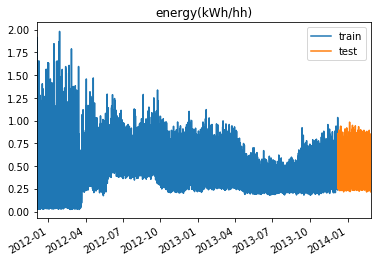

In [12]:
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Plot helpers

In [13]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std, undo_log=use_logy, legend=False):
    """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape [B,num_targets,1] that contains the
        x values of the target points.
    target_y: An array of shape [B,num_targets,1] that contains the
        y values of the target points.
    context_x: An array of shape [B,num_contexts,1] that contains 
        the x values of the context points.
    context_y: An array of shape [B,num_contexts,1] that contains 
        the y values of the context points.
    pred_y: An array of shape [B,num_targets,1] that contains the
        predicted means of the y values at the target points in target_x.
    std: An array of shape [B,num_targets,1] that contains the
        predicted std dev of the y values at the target points in target_x.
      """
    if undo_log:
        target_y=np.exp(target_y)-eps
        context_y=np.exp(context_y)-eps
    # Plot everything 
    # Note: days is first feature in x, since we made sure of that in the dataloader)
    j=0
    
    plt.plot(target_x[0,:,j], target_y[0], 'k:', linewidth=2, label='true')
    plt.plot(context_x[0,:,j], context_y[0], 'ko', markersize=6, label='input data')
    ylims=plt.ylim()
    plt.plot(target_x[0,:,j], pred_y[0], 'b', linewidth=2, label='predicted')
    plt.fill_between(
          target_x[0, :, j],
          pred_y[0, :, 0] - std[0, :, 0],
          pred_y[0, :, 0] + std[0, :, 0],
          alpha=0.25,
          facecolor='blue',
          interpolate=True,
    label='uncertainty')

    # Make the plot pretty
    plt.grid('off')
    plt.ylim(*ylims)
    plt.xlabel('Days')
    plt.ylabel('Energy (kWh/hh)')
    plt.grid(b=None)
    if legend:
        plt.legend()
    ax = plt.gca()
    plt.show()

In [14]:
def plot_from_loader(loader, i=0, undo_log=use_logy, title='', plot=True, legend=False):
    data = loader.collate_fn([loader.dataset[i]])
    data = [d.to(device) for d in data]
    context_x, context_y, target_x, target_y = data

    model.eval()
    with torch.no_grad():
        y_pred, kl, loss_test, y_std = model(context_x, context_y, target_x, target_y)

        if plot:
            plt.title(title+f" loss={loss_test: 2.2g}")
            plot_functions(target_x.detach().cpu().numpy(),
                            target_y.detach().cpu().numpy(),
                            context_x.detach().cpu().numpy(),
                            context_y.detach().cpu().numpy(),
                            y_pred.detach().cpu().numpy(),
                            y_std.detach().cpu().numpy(), undo_log=undo_log, legend=legend)
    return loss_test

# Dataloaders

In [15]:
data_train = SmartMeterDataSet(df_train, num_context, num_extra_target)
data_test = SmartMeterDataSet(df_test, num_context, num_extra_target)

In [16]:
loader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, 
    collate_fn=collate_fns(num_context, num_extra_target, sample=True),
    num_workers=num_workers,
)

loader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=False, 
    collate_fn=collate_fns(num_context, num_extra_target, sample=False)
)

# Run

In [17]:
x, y, _, _ = next(iter(loader_train))
x.shape, y.shape

(torch.Size([32, 5, 16]), torch.Size([32, 5, 1]))

In [18]:
from src.models.modules import DeterministicEncoder

In [79]:
class TransformerTimeseries(nn.Module):
    """Simple transformer model to predict seq of y given seq of x."""

    def __init__(self,
                 channels,
                 num_outputs,
                 lstm_channels=256,
                 dropout=0,
                 nhead=16,
                 lstm_layers=8):
        super().__init__()
        self.num_outputs = num_outputs
        encoder_channels = lstm_channels


        self.encoder = DeterministicEncoder(
            input_dim=channels+num_outputs,
            x_dim=channels,
            hidden_dim=lstm_channels,
            n_d_encoder_layers=lstm_layers,
            n_heads=nhead,
            dropout=dropout,
            attention_dropout=dropout
        )

        # head to reduce features
        self.decoder = nn.Linear(lstm_channels, num_outputs * 2)

    def forward(self, context_x, context_y, target_x, target_y=None):
         
        q = self.encoder(context_x, context_y, target_x)
        
        # Reduce features
        output = self.decoder(q)

        loc = output[:, :, :self.num_outputs]
        log_scale = output[:, :, self.num_outputs:] + math.log(0.1)
        scale = log_scale.exp()

        dist = torch.distributions.Normal(loc=loc, scale=scale)
        dist_t = torch.distributions.Normal(loc=loc[:, context_x.shape[1]:], scale=scale[:, context_x.shape[1]:])

        if target_y is not None:
            loss = -dist.log_prob(target_y).mean()
#             loss = -dist_t.log_prob(target_y[:, context_x.shape[1]:]).mean()
        else:
            loss = None

        y_pred = dist.rsample() if self.training else dist.loc

        return y_pred, torch.Tensor([0]), loss, dist.scale

In [95]:

model = TransformerTimeseries(
    channels=x.shape[-1],
    num_outputs=y.shape[-1],
    lstm_channels=240,
    nhead=12,
    lstm_layers=4,
    dropout=0.5,
).cuda()
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [96]:
from torchsummaryX import summary
data = next(iter(loader_train))
data = [d.to(device) for d in data]
context_x, context_y, target_x, target_y = data
with torch.no_grad():
    model.eval()
    summary(model, context_x, context_y, target_x, target_y)
    dist, log_p, kl, loss = model(context_x, context_y, target_x, target_y)

                                          Kernel Shape      Output Shape  Params Mult-Adds
Layer                                                                                     
0_encoder._input_layer.Linear_linear         [17, 240]     [32, 59, 240]   4.32k     4.08k
1_encoder._input_layer.ReLU_act                      -     [32, 59, 240]       -         -
2_encoder._input_layer.BatchNorm2d_norm          [240]  [32, 240, 59, 1]   480.0     240.0
3_encoder._input_layer.Dropout2d_dropout             -  [32, 240, 59, 1]       -         -
4_encoder._d_encoder.0.Linear_linear        [240, 240]     [32, 59, 240]  57.84k     57.6k
5_encoder._d_encoder.0.ReLU_act                      -     [32, 59, 240]       -         -
6_encoder._d_encoder.0.BatchNorm2d_norm          [240]  [32, 240, 59, 1]   480.0     240.0
7_encoder._d_encoder.0.Dropout2d_dropout             -  [32, 240, 59, 1]       -         -
8_encoder._d_encoder.1.Linear_linear        [240, 240]     [32, 59, 240]  57.84k     57.6k

In [97]:

import gc
gc.collect()
torch.cuda.empty_cache()

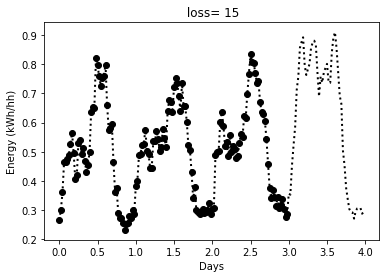

tensor(15.2668, device='cuda:0')

In [98]:
# Lets choose a challenging time to forecast
vis_i = 670 # 290 # 1600
plot_from_loader(loader_test, i=vis_i)

0, i=0, loss: 12.04, test: 15.74, grad_norm:  78, std:  0.1
0, i=100, loss: 0.5989, test: 0.167, grad_norm:  30, std:  0.29
0, i=200, loss: -0.06124, test: -0.1891, grad_norm:  4.1, std:  0.26
0, i=300, loss: -0.1909, test: -0.3421, grad_norm:  3.1, std:  0.23
0, i=400, loss: -0.2281, test: -0.3924, grad_norm:  3, std:  0.21
0, i=500, loss: -0.2619, test: -0.442, grad_norm:  2.2, std:  0.21
0, i=600, loss: -0.2581, test: -0.61, grad_norm:  13, std:  0.2
0, i=700, loss: -0.4709, test: -0.7202, grad_norm:  3.6, std:  0.16
0, i=800, loss: -0.6467, test: -0.6779, grad_norm:  6.9, std:  0.15
0, i=900, loss: -0.6943, test: -0.6057, grad_norm:  2.1, std:  0.16
0, i=1000, loss: -0.6559, test: -0.7962, grad_norm:  2.1, std:  0.15


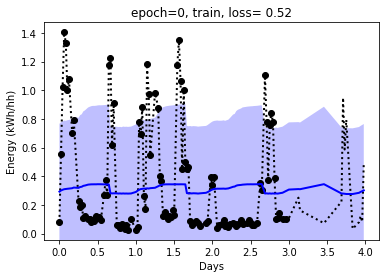

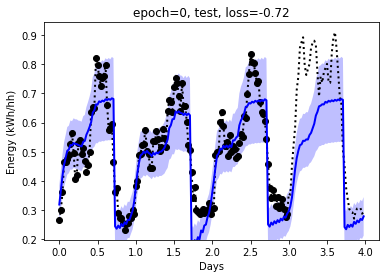

epoch: 0, loss: -0.8176, loss_test:-0.7223, kl= 0, grad_norm:  6.1


1, i=0, loss: -0.7496, test: -0.7354, grad_norm:  6.3, std:  0.18
1, i=100, loss: -0.6241, test: -0.6678, grad_norm:  2, std:  0.17
1, i=200, loss: -0.8209, test: -0.66, grad_norm:  3.1, std:  0.15
1, i=300, loss: -0.6764, test: -0.4151, grad_norm:  3.1, std:  0.14
1, i=400, loss: -0.6151, test: -0.5367, grad_norm:  8.8, std:  0.13
1, i=500, loss: -0.7931, test: 0.04736, grad_norm:  2.1, std:  0.14
1, i=600, loss: -0.7506, test: -0.1677, grad_norm:  8.1, std:  0.13
1, i=700, loss: -1.037, test: -0.4353, grad_norm:  10, std:  0.11
1, i=800, loss: -0.7155, test: -0.353, grad_norm:  5.4, std:  0.13
1, i=900, loss: -0.7385, test: -0.2933, grad_norm:  4.7, std:  0.13
1, i=1000, loss: -0.9477, test: -0.3374, grad_norm:  7.9, std:  0.13


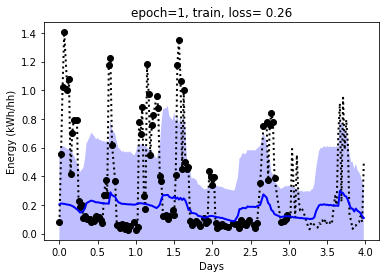

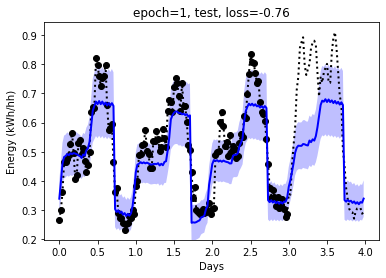

epoch: 1, loss: -0.5278, loss_test:-0.7628, kl= 0, grad_norm:  10


2, i=0, loss: -0.7722, test: -0.8725, grad_norm:  8.3, std:  0.12
2, i=100, loss: -0.8826, test: -0.686, grad_norm:  12, std:  0.13
2, i=200, loss: -0.3339, test: -0.5383, grad_norm:  41, std:  0.12
2, i=300, loss: -1.037, test: -0.8372, grad_norm:  9.1, std:  0.1
2, i=400, loss: -0.7451, test: -0.9627, grad_norm:  14, std:  0.13
2, i=500, loss: -0.833, test: -0.2225, grad_norm:  4.9, std:  0.13
2, i=600, loss: -0.8813, test: -0.2771, grad_norm:  23, std:  0.14
2, i=700, loss: -0.9797, test: -0.8626, grad_norm:  3.9, std:  0.13
2, i=800, loss: -0.9972, test: -0.5679, grad_norm:  2.6, std:  0.11
2, i=900, loss: -0.9832, test: -0.7129, grad_norm:  4.7, std:  0.11
2, i=1000, loss: -1.015, test: -0.3887, grad_norm:  7.1, std:  0.11


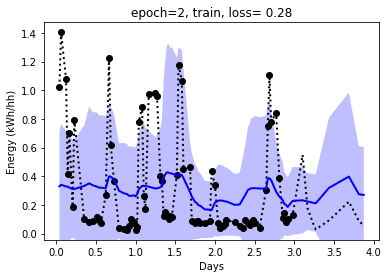

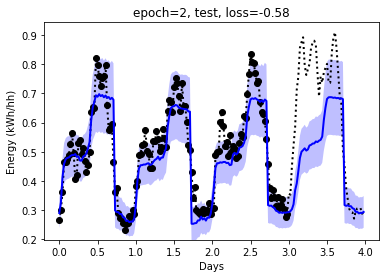

epoch: 2, loss: -0.6806, loss_test:-0.5781, kl= 0, grad_norm:  21


3, i=0, loss: -0.8702, test: -0.4559, grad_norm:  2.8, std:  0.15
3, i=100, loss: -1.048, test: -0.06519, grad_norm:  7.3, std:  0.12
3, i=200, loss: -0.8716, test: -0.9633, grad_norm:  13, std:  0.14
3, i=300, loss: -0.9482, test: -0.7146, grad_norm:  20, std:  0.12
3, i=400, loss: -0.6112, test: -0.8644, grad_norm:  5.7, std:  0.15
3, i=500, loss: -0.9254, test: -0.825, grad_norm:  5.8, std:  0.14
3, i=600, loss: -1.037, test: -0.2158, grad_norm:  20, std:  0.12
3, i=700, loss: -1.173, test: -0.6178, grad_norm:  15, std:  0.099
3, i=800, loss: 0.3993, test: -0.9172, grad_norm:  51, std:  0.12
3, i=900, loss: -1.027, test: -0.4966, grad_norm:  11, std:  0.11
3, i=1000, loss: -0.7792, test: -0.7599, grad_norm:  11, std:  0.1


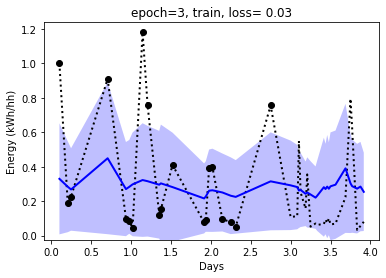

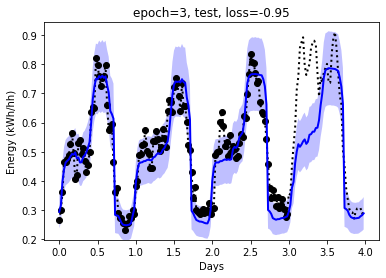

epoch: 3, loss: -1.083, loss_test:-0.9534, kl= 0, grad_norm:  6.1


4, i=0, loss: -1.002, test: -0.9325, grad_norm:  3.9, std:  0.12
4, i=100, loss: -0.9589, test: -0.4892, grad_norm:  17, std:  0.11
4, i=200, loss: -0.8659, test: -1.108, grad_norm:  4.7, std:  0.12
4, i=300, loss: -0.8368, test: -0.8247, grad_norm:  32, std:  0.095
4, i=400, loss: -1.015, test: -0.8897, grad_norm:  11, std:  0.1
4, i=500, loss: -0.9247, test: -0.5902, grad_norm:  5.4, std:  0.11
4, i=600, loss: -1.149, test: -0.518, grad_norm:  5.1, std:  0.1
4, i=700, loss: -1.036, test: -0.7103, grad_norm:  11, std:  0.1
4, i=800, loss: -0.9964, test: -0.7723, grad_norm:  11, std:  0.11
4, i=900, loss: -1.032, test: -0.5893, grad_norm:  16, std:  0.1
4, i=1000, loss: -0.8698, test: -1.013, grad_norm:  7.3, std:  0.13


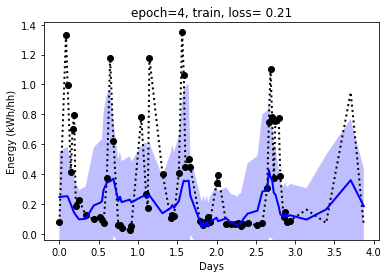

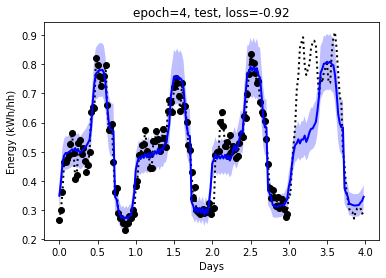

epoch: 4, loss: -0.689, loss_test:-0.9221, kl= 0, grad_norm:  10


5, i=0, loss: -0.9644, test: -0.8801, grad_norm:  17, std:  0.12
5, i=100, loss: -0.8857, test: -0.9244, grad_norm:  12, std:  0.12
5, i=200, loss: -1.08, test: -0.5578, grad_norm:  12, std:  0.11
5, i=300, loss: -0.9826, test: -0.9484, grad_norm:  31, std:  0.12
5, i=400, loss: -1.202, test: -0.6057, grad_norm:  8, std:  0.097
5, i=500, loss: -1.112, test: -0.6324, grad_norm:  10, std:  0.1
5, i=600, loss: -0.9642, test: -0.7798, grad_norm:  9.6, std:  0.097
5, i=700, loss: -1.036, test: -0.6894, grad_norm:  7.9, std:  0.1
5, i=800, loss: -0.7602, test: -0.9645, grad_norm:  6.3, std:  0.15
5, i=900, loss: -0.7256, test: -0.5929, grad_norm:  6, std:  0.11
5, i=1000, loss: -1.194, test: -0.9107, grad_norm:  4.3, std:  0.11


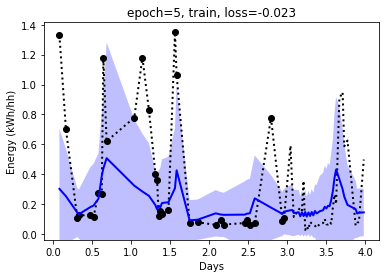

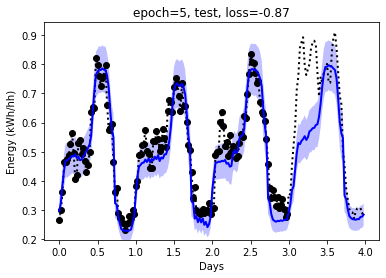

epoch: 5, loss: -0.968, loss_test:-0.8714, kl= 0, grad_norm:  21


6, i=0, loss: -1.11, test: -0.8411, grad_norm:  6.4, std:  0.11
6, i=100, loss: -0.8391, test: -0.6171, grad_norm:  19, std:  0.1
6, i=200, loss: -1.003, test: -0.6992, grad_norm:  13, std:  0.11
6, i=300, loss: -0.4235, test: -1.009, grad_norm:  20, std:  0.12
6, i=400, loss: -1.074, test: -0.4491, grad_norm:  8.8, std:  0.11
6, i=500, loss: -1.138, test: -0.793, grad_norm:  11, std:  0.11
6, i=600, loss: -0.9589, test: -0.9591, grad_norm:  5.7, std:  0.11
6, i=700, loss: -1.184, test: -0.1674, grad_norm:  11, std:  0.097
6, i=800, loss: -0.9475, test: -0.9495, grad_norm:  4.4, std:  0.11
6, i=900, loss: -0.9704, test: -1.019, grad_norm:  13, std:  0.12
6, i=1000, loss: -0.9752, test: -0.5989, grad_norm:  13, std:  0.11


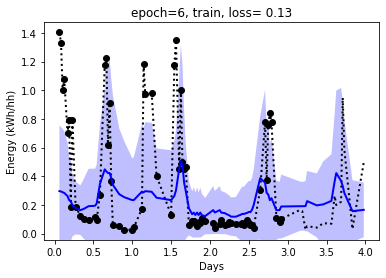

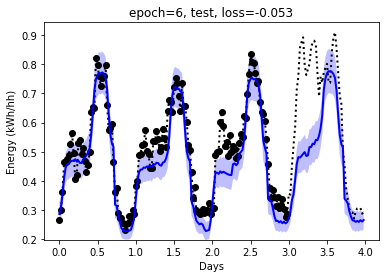

epoch: 6, loss: -1.387, loss_test:-0.0528, kl= 0, grad_norm:  16


7, i=0, loss: -0.967, test: 0.1934, grad_norm:  21, std:  0.1
7, i=100, loss: -0.9853, test: -0.7837, grad_norm:  12, std:  0.12
7, i=200, loss: -1.006, test: -0.8408, grad_norm:  2.6, std:  0.11
7, i=300, loss: -0.2649, test: -0.8445, grad_norm:  7.4, std:  0.13
7, i=400, loss: -1.033, test: -0.6261, grad_norm:  23, std:  0.089
7, i=500, loss: -1.191, test: -0.9655, grad_norm:  6.7, std:  0.094
7, i=600, loss: -0.8756, test: -0.8906, grad_norm:  7.2, std:  0.11
7, i=700, loss: -1.005, test: -0.6024, grad_norm:  13, std:  0.11
7, i=800, loss: -0.9827, test: -0.9452, grad_norm:  11, std:  0.1
7, i=900, loss: -1.038, test: -0.9476, grad_norm:  5.4, std:  0.11
7, i=1000, loss: -1.021, test: -0.6949, grad_norm:  5.5, std:  0.1


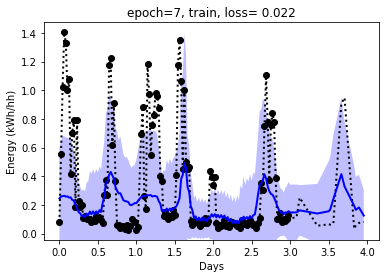

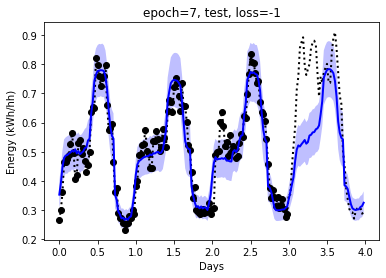

epoch: 7, loss: -0.8406, loss_test:-0.9973, kl= 0, grad_norm:  8.4


8, i=0, loss: -0.9702, test: -1.057, grad_norm:  7.7, std:  0.13
8, i=100, loss: -0.8255, test: -0.8468, grad_norm:  12, std:  0.17
8, i=200, loss: -1.138, test: -0.9248, grad_norm:  3, std:  0.12
8, i=300, loss: -1.038, test: -0.9534, grad_norm:  13, std:  0.11
8, i=400, loss: -0.9183, test: -0.8385, grad_norm:  9.8, std:  0.12
8, i=500, loss: -1.103, test: -0.9845, grad_norm:  4.7, std:  0.11
8, i=600, loss: -1.14, test: -0.8203, grad_norm:  4.2, std:  0.11
8, i=700, loss: -0.8618, test: -0.6299, grad_norm:  27, std:  0.092
8, i=800, loss: -1.237, test: -0.5416, grad_norm:  4.6, std:  0.085
8, i=900, loss: -1.115, test: -0.4566, grad_norm:  8.5, std:  0.11
8, i=1000, loss: -1.299, test: -0.7494, grad_norm:  5.9, std:  0.096


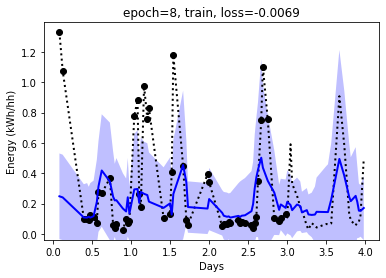

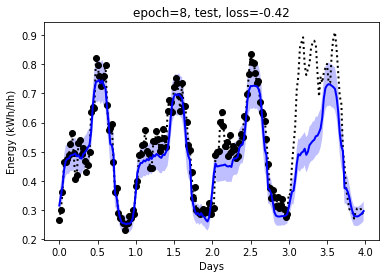

epoch: 8, loss: -1.332, loss_test:-0.4193, kl= 0, grad_norm:  14


9, i=0, loss: -1.132, test: -0.1976, grad_norm:  4.3, std:  0.11
9, i=100, loss: -1.113, test: -0.9283, grad_norm:  14, std:  0.12
9, i=200, loss: -1.25, test: -0.9692, grad_norm:  3.4, std:  0.087
9, i=300, loss: -1.153, test: -0.3436, grad_norm:  9.8, std:  0.092
9, i=400, loss: -0.9789, test: -0.531, grad_norm:  3.8, std:  0.12
9, i=500, loss: -1.04, test: -0.8174, grad_norm:  13, std:  0.11
9, i=600, loss: -1.06, test: -0.6715, grad_norm:  5, std:  0.1
9, i=700, loss: -0.8597, test: -1.139, grad_norm:  8.5, std:  0.13
9, i=800, loss: -1.292, test: -0.6086, grad_norm:  7, std:  0.088
9, i=900, loss: -0.9645, test: -0.7861, grad_norm:  4.2, std:  0.1
9, i=1000, loss: -1.21, test: -0.4638, grad_norm:  5.9, std:  0.09


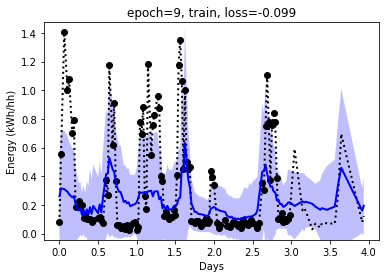

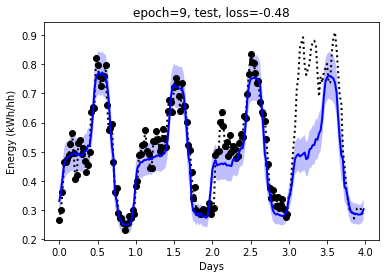

epoch: 9, loss: -0.8244, loss_test:-0.4845, kl= 0, grad_norm:  21


10, i=0, loss: -0.9398, test: -0.5732, grad_norm:  9.5, std:  0.13
10, i=100, loss: -1.17, test: -0.7597, grad_norm:  7.5, std:  0.12
10, i=200, loss: -0.9086, test: -0.3216, grad_norm:  5.8, std:  0.11
10, i=300, loss: -0.8647, test: -0.5269, grad_norm:  4.2, std:  0.13
10, i=400, loss: -0.896, test: -0.6506, grad_norm:  14, std:  0.089
10, i=500, loss: -1.287, test: -0.476, grad_norm:  2.8, std:  0.087
10, i=600, loss: -1.075, test: -0.7489, grad_norm:  12, std:  0.081
10, i=700, loss: -1.046, test: -0.9166, grad_norm:  3.7, std:  0.12
10, i=800, loss: -0.9793, test: -0.5583, grad_norm:  6, std:  0.11
10, i=900, loss: -1.189, test: -0.7897, grad_norm:  12, std:  0.09
10, i=1000, loss: -1.21, test: -0.7186, grad_norm:  5.3, std:  0.1


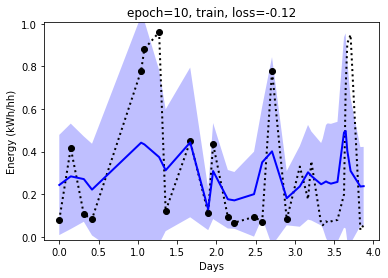

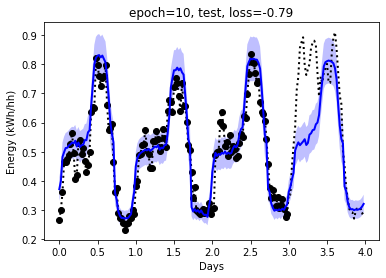

epoch: 10, loss: -1.216, loss_test:-0.787, kl= 0, grad_norm:  8.2


11, i=0, loss: -1.125, test: -0.7693, grad_norm:  13, std:  0.093
11, i=100, loss: -1.003, test: -1.058, grad_norm:  8.6, std:  0.12
11, i=200, loss: -1.114, test: -0.5672, grad_norm:  9.8, std:  0.096


KeyboardInterrupt: 

In [99]:
epochs = 20
grad_clip = 10
history = []
for epoch in tqdm(range(epochs), unit='epoch'):

    pbar = tqdm(loader_train, unit='batch')
    for i, data in enumerate(pbar):
        model.train()
        assert all(torch.isfinite(d).all() for d in data)
        data = [d.to(device) for d in data]
        context_x, context_y, target_x, target_y = data

        optim.zero_grad()
        y_pred, kl, loss, y_std = model(context_x, context_y, target_x, target_y)

        # These attentive NP models work great when you need uncertainty, but still seem a bit unstable. 
        # Sometimes they produce nans, especically if the data is not fully normalized. 
        assert torch.isfinite(y_pred.sum())
        if not torch.isfinite(loss):
            logger.error("loss is not finite")
            continue
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        if not np.isfinite(grad_norm):
            logger.error("grad_norm is not finite")
            continue
        optim.step()

        if i%100==0:
            model.eval()
            test_loss = plot_from_loader(loader_test, i=vis_i, plot=False)
            pbar.set_description(f"{epoch}, loss: {loss.item():4.4g}, test: {test_loss.item():4.4g}")
            print(f"{epoch}, i={i}, loss: {loss.item():4.4g}, test: {test_loss.item():4.4g}, grad_norm: {grad_norm: 2.2g}, std: {y_std.mean().item(): 2.2g}")
            
            history.append(dict(
                n=epoch*len(loader_train) + i,
                epoch=epoch,
                i=i,
                loss=loss.item(),
                kl=kl.mean().item(),
                test_loss=test_loss.item(),
                y_std=y_std.mean().item(),
                grad_norm=grad_norm,
            ))
        
    test_loss = plot_from_loader(loader_train, i=vis_i, title=f'epoch={epoch}, train,')
    model.eval()
    test_loss = plot_from_loader(loader_test, i=vis_i, title=f'epoch={epoch}, test,')
    print(f"epoch: {epoch}, loss: {loss.item():4.4g}, loss_test:{test_loss.item():4.4g}, kl={kl.mean().item():2.2g}, grad_norm: {grad_norm: 2.2g}")

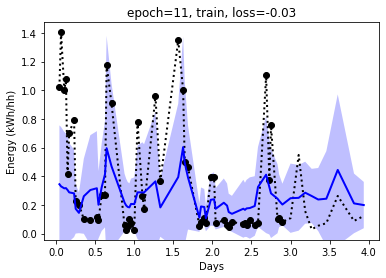

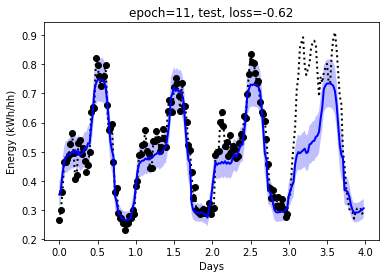

In [100]:
test_loss = plot_from_loader(loader_train, i=vis_i, title=f'epoch={epoch}, train,')
model.eval()
test_loss = plot_from_loader(loader_test, i=vis_i, title=f'epoch={epoch}, test,')

## History

In [101]:
df_hist = pd.DataFrame(history)
df_hist['n'] = df_hist['epoch'] * len(loader_train) + df_hist['i']
df_hist = df_hist.set_index('n')
df_hist.head(3)

,epoch,grad_norm,i,kl,loss,test_loss,y_std
n,,,,,,,
0,0,78.047332,0,0.0,12.035278,15.742895,0.101118
100,0,30.086547,100,0.0,0.598903,0.166957,0.286797
200,0,4.069779,200,0.0,-0.061244,-0.189053,0.259089


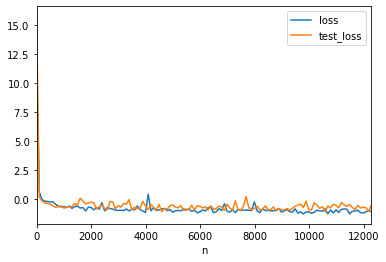

In [102]:
(df_hist[['loss', 'test_loss']]).plot()

/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/pandas/plotting/_core.py:441: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


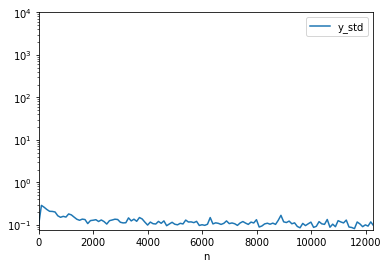

In [103]:
df_hist[['y_std']].plot(ylim=[0,1e4], logy=True)

In [104]:
df_hist[100:]

,epoch,grad_norm,i,kl,loss,test_loss,y_std
n,,,,,,,
9982,9,14.168570,100,0.0,-1.113127,-0.928341,0.115738
10082,9,3.446385,200,0.0,-1.249848,-0.969157,0.087038
10182,9,9.780797,300,0.0,-1.152946,-0.343559,0.092311
10282,9,3.800741,400,0.0,-0.978877,-0.531003,0.118821
10382,9,13.282835,500,0.0,-1.039643,-0.817430,0.105456
10482,9,4.956898,600,0.0,-1.059629,-0.671499,0.102528
10582,9,8.460106,700,0.0,-0.859704,-1.138569,0.133556
10682,9,6.977190,800,0.0,-1.292004,-0.608584,0.087684
10782,9,4.168948,900,0.0,-0.964534,-0.786123,0.103590


In [105]:
len(loader_test)

117